In [57]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Text Model (mBERT)

In [58]:
print("Loading mBERT model...")
mbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
mbert_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MBERT_MODEL_PATH = "models/mbert_model.pth"

# Load trained weights
mbert_model.load_state_dict(torch.load(MBERT_MODEL_PATH, map_location=device))
mbert_model = mbert_model.to(device)
mbert_model.eval()

print("✓ mBERT model loaded successfully!")

Loading mBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ mBERT model loaded successfully!


## 2. Visual Model (CLIP)

In [59]:
print("Loading CLIP model...")
CLIP_MODEL_PATH = "models/clip_model.pth"
# CLIP Classifier class (same as training)
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2, dropout=0.3):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        hidden_size = self.clip.config.projection_dim
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, pixel_values):
        vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
        image_embeds = vision_outputs.pooler_output
        image_embeds = self.clip.visual_projection(image_embeds)
        logits = self.classifier(image_embeds)
        return logits

# Load CLIP
clip_base = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPClassifier(clip_base, num_classes=2)

# Load trained weights
clip_model.load_state_dict(torch.load(CLIP_MODEL_PATH, map_location=device))
clip_model = clip_model.to(device)
clip_model.eval()

print("✓ CLIP model loaded successfully!")

Loading CLIP model...
✓ CLIP model loaded successfully!


#  Generate Predictions from Base Models

## Helper Functions

In [60]:
def get_text_predictions(texts, model, tokenizer, device, batch_size=16):
    """Get probability predictions from text model (mBERT)"""
    model.eval()
    all_probs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Text predictions"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoding = tokenizer(
                batch_texts,
                add_special_tokens=True,
                max_length=MAX_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            all_probs.append(probs.cpu().numpy())
    
    return np.vstack(all_probs)


def get_image_predictions(image_names, img_dir, model, processor, device, batch_size=16):
    """Get probability predictions from visual model (CLIP)"""
    model.eval()
    all_probs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(image_names), batch_size), desc="Image predictions"):
            batch_names = image_names[i:i+batch_size]
            batch_images = []
            
            # Load images
            for img_name in batch_names:
                img_path = os.path.join(img_dir, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                except:
                    img = Image.new('RGB', (224, 224), (128, 128, 128))
                batch_images.append(img)
            
            # Process images
            inputs = processor(images=batch_images, return_tensors="pt")
            pixel_values = inputs['pixel_values'].to(device)
            
            # Get predictions
            outputs = model(pixel_values)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
    
    return np.vstack(all_probs)

print("Prediction functions defined!")

Prediction functions defined!


In [61]:
# Load training data with processed text
print("Loading training data...")
train_df = pd.read_csv('data/process/train_dataset_cleaned.csv')
print(f"✓ Training data loaded: {train_df.shape}")
print(f"  Columns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

Loading training data...
✓ Training data loaded: (2860, 3)
  Columns: ['Image_name', 'Label', 'Processed_Text']

First few rows:
      Image_name         Label  \
0  train0001.jpg     Political   
1  train0002.jpg  NonPolitical   
2  train0003.jpg  NonPolitical   
3  train0004.jpg  NonPolitical   
4  train0005.jpg  NonPolitical   

                                      Processed_Text  
0  হরেক রকম চোর দিয়া বানাইছো মেলা পিসি তোমার দরবা...  
1  বর যাত্রী যাওয়ার টাইমে যখব গাড়িতে জায়গা কম পড়ে...  
2  তুমিকেখা নাবলল বুকে অনেক ব্যখাহেয় ঠিক মত পানি ...  
3  যখন ভল্লুক এসে পড়ে এবং আপন এবং আপনার রেস্টফরেন...  
4  বন্ধুযখন তার গফকেকাজিন বলে পরিচয় দেয় সম্পর্কবদ...  


In [62]:
# Load test data
print("Loading test data...")
test_text_df = pd.read_csv('data/process/test_dataset_cleaned.csv')
print(f"✓ Test data loaded: {test_text_df.shape}")
print(f"  Columns: {test_text_df.columns.tolist()}")

Loading test data...
✓ Test data loaded: (330, 2)
  Columns: ['Image_name', 'Processed_Text']


In [63]:
# Create validation split (80-20 split)
print("Creating train/validation split...")
train_split, val_split = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['Label']
)

print(f"✓ Split created:")
print(f"  Training set: {train_split.shape[0]} samples")
print(f"  Validation set: {val_split.shape[0]} samples")
print(f"\nValidation label distribution:")
print(val_split['Label'].value_counts())

Creating train/validation split...
✓ Split created:
  Training set: 2288 samples
  Validation set: 572 samples

Validation label distribution:
Label
NonPolitical    401
Political       171
Name: count, dtype: int64


In [64]:
# Define constants
MAX_LENGTH = 128
TRAIN_IMG_DIR = "data/raw/Train/Image"
TEST_IMG_DIR = "data/raw/Test/Image"

print("Constants defined:")
print(f"  MAX_LENGTH: {MAX_LENGTH}")
print(f"  TRAIN_IMG_DIR: {TRAIN_IMG_DIR}")
print(f"  TEST_IMG_DIR: {TEST_IMG_DIR}")

Constants defined:
  MAX_LENGTH: 128
  TRAIN_IMG_DIR: data/raw/Train/Image
  TEST_IMG_DIR: data/raw/Test/Image


## Load Data & Create Validation Split

## Generate Validation Predictions

In [65]:
print("Generating predictions on validation set...\n")

# Text predictions
val_texts = val_split['Processed_Text'].fillna('').tolist()
text_proba_val = get_text_predictions(val_texts, mbert_model, mbert_tokenizer, device)

# Image predictions
val_images = val_split['Image_name'].tolist()
image_proba_val = get_image_predictions(val_images, TRAIN_IMG_DIR, clip_model, clip_processor, device)

# True labels
y_val = (val_split['Label'] == 'Political').astype(int).values

print(f"\nValidation predictions generated!")
print(f"Text probabilities shape: {text_proba_val.shape}")
print(f"Image probabilities shape: {image_proba_val.shape}")
print(f"Labels shape: {y_val.shape}")

Generating predictions on validation set...



Image predictions: 100%|██████████| 36/36 [00:37<00:00,  1.05s/it]


Validation predictions generated!
Text probabilities shape: (572, 2)
Image probabilities shape: (572, 2)
Labels shape: (572,)


## Analyze Base Model Performance

In [66]:
# =============================
# BASE MODEL PERFORMANCE
# =============================
text_preds_val = np.argmax(text_proba_val, axis=1)
image_preds_val = np.argmax(image_proba_val, axis=1)

text_acc = accuracy_score(y_val, text_preds_val)
text_f1 = f1_score(y_val, text_preds_val, average='macro')

image_acc = accuracy_score(y_val, image_preds_val)
image_f1 = f1_score(y_val, image_preds_val, average='macro')

print("=" * 60)
print("BASE MODEL PERFORMANCE ON VALIDATION SET")
print("=" * 60)
print(f"\nText Model (mBERT):")
print(f"  Accuracy: {text_acc:.4f}")
print(f"  F1 Score: {text_f1:.4f}")

print(f"\nImage Model (CLIP):")
print(f"  Accuracy: {image_acc:.4f}")
print(f"  F1 Score: {image_f1:.4f}")

print(f"\n{'='*60}")

BASE MODEL PERFORMANCE ON VALIDATION SET

Text Model (mBERT):
  Accuracy: 0.8969
  F1 Score: 0.8676

Image Model (CLIP):
  Accuracy: 0.9266
  F1 Score: 0.9096



#  Engineer Meta-Features for Stacking

In [67]:
# =============================
# FEATURE ENGINEERING FOR META-MODEL
# =============================

def create_stacking_features(text_proba, image_proba):
    """
    Create engineered features for meta-model
    
    Features:
    1-2: Raw text probabilities [NonPol, Pol]
    3-4: Raw image probabilities [NonPol, Pol]
    5: Text confidence (max probability)
    6: Image confidence (max probability)
    7: Models agreement (binary: do they predict same class?)
    8: Disagreement magnitude (absolute difference in Political prob)
    9: Both predict Political (product of Political probs)
    10: Both predict NonPolitical (product of NonPolitical probs)
    11: Average Political probability
    12: Max Political probability
    13: Min Political probability
    14: Difference (Text Political - Image Political)
    """
    features = np.column_stack([
        # Base probabilities (4 features)
        text_proba[:, 0],              # Text: prob NonPolitical
        text_proba[:, 1],              # Text: prob Political
        image_proba[:, 0],             # Image: prob NonPolitical
        image_proba[:, 1],             # Image: prob Political
        
        # Confidence features (2 features)
        np.max(text_proba, axis=1),    # Text confidence
        np.max(image_proba, axis=1),   # Image confidence
        
        # Agreement features (2 features)
        (np.argmax(text_proba, axis=1) == np.argmax(image_proba, axis=1)).astype(float),  # Agreement
        np.abs(text_proba[:, 1] - image_proba[:, 1]),  # Disagreement magnitude
        
        # Interaction features (2 features)
        text_proba[:, 1] * image_proba[:, 1],  # Both say Political
        text_proba[:, 0] * image_proba[:, 0],  # Both say NonPolitical
        
        # Statistical features (4 features)
        (text_proba[:, 1] + image_proba[:, 1]) / 2,  # Average Political prob
        np.maximum(text_proba[:, 1], image_proba[:, 1]),  # Max Political prob
        np.minimum(text_proba[:, 1], image_proba[:, 1]),  # Min Political prob
        text_proba[:, 1] - image_proba[:, 1],  # Difference (Text - Image)
    ])
    
    return features

# Create validation features
X_val_stacking = create_stacking_features(text_proba_val, image_proba_val)

print(f"Stacking features shape: {X_val_stacking.shape}")
print(f"Total features: {X_val_stacking.shape[1]}")
print(f"\nFeature breakdown:")
print(f"  - Base probabilities: 4")
print(f"  - Confidence features: 2")
print(f"  - Agreement features: 2")
print(f"  - Interaction features: 2")
print(f"  - Statistical features: 4")
print(f"  - Total: 14 features")

Stacking features shape: (572, 14)
Total features: 14

Feature breakdown:
  - Base probabilities: 4
  - Confidence features: 2
  - Agreement features: 2
  - Interaction features: 2
  - Statistical features: 4
  - Total: 14 features


# Train Meta-Model (Logistic Regression)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

print("Training Logistic Regression meta-model with Grid Search...\n")

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'class_weight': ['balanced', None],
    'solver': ['lbfgs', 'liblinear']
}

# Create base meta-model
meta_model_base = LogisticRegression(max_iter=1000, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    meta_model_base,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_val_stacking, y_val)

# Best model
meta_model = grid_search.best_estimator_

print(f"\n{'='*60}")
print("GRID SEARCH RESULTS")
print(f"{'='*60}")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")
print(f"\n{'='*60}")

Training Logistic Regression meta-model with Grid Search...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

GRID SEARCH RESULTS

Best parameters: {'C': 1.0, 'class_weight': None, 'solver': 'lbfgs'}
Best CV F1 Score: 0.9480



## Analyze Meta-Model Performance

In [69]:
# =============================
# META-MODEL PERFORMANCE
# =============================
ensemble_preds_val = meta_model.predict(X_val_stacking)
ensemble_proba_val = meta_model.predict_proba(X_val_stacking)

ensemble_acc = accuracy_score(y_val, ensemble_preds_val)
ensemble_f1 = f1_score(y_val, ensemble_preds_val, average='macro')

print("=" * 60)
print("ENSEMBLE MODEL PERFORMANCE")
print("=" * 60)
print(f"\nEnsemble (Stacking):")
print(f"  Accuracy: {ensemble_acc:.4f}")
print(f"  F1 Score: {ensemble_f1:.4f}")

print(f"\n{'='*60}")
print("PERFORMANCE COMPARISON")
print(f"{'='*60}")
print(f"\nText Model:     Acc={text_acc:.4f}, F1={text_f1:.4f}")
print(f"Image Model:    Acc={image_acc:.4f}, F1={image_f1:.4f}")
print(f"Ensemble:       Acc={ensemble_acc:.4f}, F1={ensemble_f1:.4f}")

print(f"\n{'='*60}")
print("IMPROVEMENTS")
print(f"{'='*60}")
print(f"Accuracy improvement over Text:  {(ensemble_acc - text_acc)*100:+.2f}%")
print(f"Accuracy improvement over Image: {(ensemble_acc - image_acc)*100:+.2f}%")
print(f"F1 improvement over Text:        {(ensemble_f1 - text_f1)*100:+.2f}%")
print(f"F1 improvement over Image:       {(ensemble_f1 - image_f1)*100:+.2f}%")
print(f"\n{'='*60}")

ENSEMBLE MODEL PERFORMANCE

Ensemble (Stacking):
  Accuracy: 0.9563
  F1 Score: 0.9478

PERFORMANCE COMPARISON

Text Model:     Acc=0.8969, F1=0.8676
Image Model:    Acc=0.9266, F1=0.9096
Ensemble:       Acc=0.9563, F1=0.9478

IMPROVEMENTS
Accuracy improvement over Text:  +5.94%
Accuracy improvement over Image: +2.97%
F1 improvement over Text:        +8.02%
F1 improvement over Image:       +3.82%



## Generate Test Predictions for Ensemble

In [70]:
print("Generating predictions on test set...\n")

# Text predictions on test set
test_texts = test_text_df['Processed_Text'].fillna('').tolist()
text_proba_test = get_text_predictions(test_texts, mbert_model, mbert_tokenizer, device)

# Image predictions on test set
test_images = test_text_df['Image_name'].tolist()
image_proba_test = get_image_predictions(test_images, TEST_IMG_DIR, clip_model, clip_processor, device)

# Create test features for ensemble
X_test_stacking = create_stacking_features(text_proba_test, image_proba_test)

# Get ensemble predictions on test set
ensemble_proba_test = meta_model.predict_proba(X_test_stacking)
ensemble_preds_test = meta_model.predict(X_test_stacking)

print(f"\nTest predictions generated!")
print(f"Text probabilities shape: {text_proba_test.shape}")
print(f"Image probabilities shape: {image_proba_test.shape}")
print(f"Test stacking features shape: {X_test_stacking.shape}")
print(f"Ensemble probabilities shape: {ensemble_proba_test.shape}")
print(f"\nEnsemble test predictions distribution:")
print(f"  Political: {(ensemble_preds_test == 1).sum()}")
print(f"  NonPolitical: {(ensemble_preds_test == 0).sum()}")

Generating predictions on test set...



Image predictions: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Test predictions generated!
Text probabilities shape: (330, 2)
Image probabilities shape: (330, 2)
Test stacking features shape: (330, 14)
Ensemble probabilities shape: (330, 2)

Ensemble test predictions distribution:
  Political: 125
  NonPolitical: 205


# Late Fusion
- Between first model build with deep learing and stacking model build with logistic regresion


In [71]:
# =============================
# LATE FUSION: Combining Neural Network & Ensemble Predictions
# =============================
print("="*60)
print("LATE FUSION IMPLEMENTATION")
print("="*60)
print("\nCombining predictions from:")
print("  1. Deep Learning Model (Neural Network on text features)")
print("  2. Stacking Ensemble (mBERT + CLIP with Logistic Regression)")
print()

LATE FUSION IMPLEMENTATION

Combining predictions from:
  1. Deep Learning Model (Neural Network on text features)
  2. Stacking Ensemble (mBERT + CLIP with Logistic Regression)



### STEP 1: Load Neural Network Model & Get Predictions

In [72]:
print("Generating political features for test data...\n")

# Load political-specific words
political_words_df = pd.read_csv('data/words/political_specific_words.csv')
political_specific_words = set(political_words_df['word'].str.lower().tolist())
print(f"✓ Loaded {len(political_specific_words)} political-specific words")

# Feature extraction function
def extract_political_features(text, political_words):
    """Extract political-specific word features from text"""
    if pd.isna(text) or text == '':
        return {'political_specific_count': 0, 'political_specific_ratio': 0.0}
    
    words = text.lower().split()
    word_count = len(words)
    
    political_count = sum(1 for word in words if word in political_words)
    political_ratio = political_count / word_count if word_count > 0 else 0.0
    
    return {
        'political_specific_count': political_count,
        'political_specific_ratio': political_ratio
    }

# Generate features for test data
test_features = test_text_df['Processed_Text'].apply(
    lambda x: extract_political_features(x, political_specific_words)
)
test_features_df = pd.DataFrame(test_features.tolist())

print(f"✓ Generated features for test set")
print(f"  Shape: {test_features_df.shape}")
print(f"  Mean political_specific_count: {test_features_df['political_specific_count'].mean():.2f}")
print(f"  Mean political_specific_ratio: {test_features_df['political_specific_ratio'].mean():.4f}")

Generating political features for test data...

✓ Loaded 935 political-specific words
✓ Generated features for test set
  Shape: (330, 2)
  Mean political_specific_count: 2.59
  Mean political_specific_ratio: 0.1559


### Generate Political Features for Test Data

In [73]:
print("Step 1: Loading Neural Network model...\n")

# Define the SimpleNN architecture (same as in training)
class SimpleNN(nn.Module):
    def __init__(self, input_size=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Load the neural network model
nn_model = SimpleNN(input_size=2).to(device)
nn_model.load_state_dict(torch.load('models/neural_network_model.pth', map_location=device))
nn_model.eval()
print("✓ Neural Network model loaded!")

# Load feature-engineered data (contains political_specific_count and political_specific_ratio)
print("\n✓ Loading feature-engineered data for training...")
train_features_df = pd.read_csv('data/feature/feature_engineering_txt.csv')
print(f"✓ Feature data loaded: {train_features_df.shape}")

# Merge features with train_split and val_split
train_split_with_features = train_split.merge(
    train_features_df[['Image_name', 'political_specific_count', 'political_specific_ratio']], 
    on='Image_name', 
    how='left'
)
val_split_with_features = val_split.merge(
    train_features_df[['Image_name', 'political_specific_count', 'political_specific_ratio']], 
    on='Image_name', 
    how='left'
)

# Combine test_text_df with generated features
test_with_features = pd.concat([test_text_df, test_features_df], axis=1)

# Create scaler from training data
from sklearn.preprocessing import StandardScaler
print("\n✓ Creating scaler from training data...")
scaler = StandardScaler()
X_train_for_scaler = train_split_with_features[['political_specific_count', 'political_specific_ratio']].fillna(0)
scaler.fit(X_train_for_scaler)
print("✓ Scaler created!")

# Get validation predictions from Neural Network
print("\nGenerating Neural Network predictions on validation set...")
val_features_nn = val_split_with_features[['political_specific_count', 'political_specific_ratio']].fillna(0)
val_features_nn_scaled = scaler.transform(val_features_nn)
val_features_nn_tensor = torch.FloatTensor(val_features_nn_scaled).to(device)

with torch.no_grad():
    nn_proba_val = nn_model(val_features_nn_tensor).cpu().numpy()
    nn_preds_val = (nn_proba_val > 0.5).astype(int).flatten()

# Get test predictions from Neural Network
print("Generating Neural Network predictions on test set...")
test_features_nn = test_with_features[['political_specific_count', 'political_specific_ratio']].fillna(0)
test_features_nn_scaled = scaler.transform(test_features_nn)
test_features_nn_tensor = torch.FloatTensor(test_features_nn_scaled).to(device)

with torch.no_grad():
    nn_proba_test = nn_model(test_features_nn_tensor).cpu().numpy()
    nn_preds_test = (nn_proba_test > 0.5).astype(int).flatten()

print(f"\nNeural Network predictions generated!")
print(f"  Val shape: {nn_proba_val.shape}")
print(f"  Test shape: {nn_proba_test.shape}")

Step 1: Loading Neural Network model...

✓ Neural Network model loaded!

✓ Loading feature-engineered data for training...
✓ Feature data loaded: (2860, 6)

✓ Creating scaler from training data...
✓ Scaler created!

Generating Neural Network predictions on validation set...
Generating Neural Network predictions on test set...

Neural Network predictions generated!
  Val shape: (572, 1)
  Test shape: (330, 1)


### STEP 2: Get Ensemble Predictions

In [74]:
print("\nStep 2: Ensemble predictions available!")
print(f"  Ensemble val predictions: {ensemble_proba_val.shape}")
print(f"  Ensemble test predictions: {ensemble_proba_test.shape}")


Step 2: Ensemble predictions available!
  Ensemble val predictions: (572, 2)
  Ensemble test predictions: (330, 2)


### STEP 3: Analyze Individual Model Performance on Validation

In [75]:
print("\n" + "="*60)
print("INDIVIDUAL MODEL PERFORMANCE (Validation Set)")
print("="*60)

nn_acc_val = accuracy_score(y_val, nn_preds_val)
nn_f1_val = f1_score(y_val, nn_preds_val, average='macro')

print(f"\n1. Neural Network (Text Features):")
print(f"     Accuracy: {nn_acc_val:.4f}")
print(f"     F1 Score: {nn_f1_val:.4f}")

print(f"\n2. Text Model (mBERT):")
print(f"     Accuracy: {text_acc:.4f}")
print(f"     F1 Score: {text_f1:.4f}")

print(f"\n3. Image Model (CLIP):")
print(f"     Accuracy: {image_acc:.4f}")
print(f"     F1 Score: {image_f1:.4f}")

print(f"\n4. Ensemble (Stacking):")
print(f"     Accuracy: {ensemble_acc:.4f}")
print(f"     F1 Score: {ensemble_f1:.4f}")


INDIVIDUAL MODEL PERFORMANCE (Validation Set)

1. Neural Network (Text Features):
     Accuracy: 0.9021
     F1 Score: 0.8799

2. Text Model (mBERT):
     Accuracy: 0.8969
     F1 Score: 0.8676

3. Image Model (CLIP):
     Accuracy: 0.9266
     F1 Score: 0.9096

4. Ensemble (Stacking):
     Accuracy: 0.9563
     F1 Score: 0.9478


### STEP 4: Late Fusion Methods

In [76]:
print("\n" + "="*60)
print("LATE FUSION STRATEGIES")
print("="*60)

# Convert probabilities to same format (both should be [N, 2] shape)
# Neural Network outputs [N, 1], so we need to convert
nn_proba_val_2d = np.column_stack([1 - nn_proba_val, nn_proba_val])
nn_proba_test_2d = np.column_stack([1 - nn_proba_test, nn_proba_test])

# Method 1: Simple Average (Equal Weights)
print("\n1. SIMPLE AVERAGE (Equal Weights)")
avg_proba_val = (nn_proba_val_2d + ensemble_proba_val) / 2
avg_preds_val = np.argmax(avg_proba_val, axis=1)

avg_acc = accuracy_score(y_val, avg_preds_val)
avg_f1 = f1_score(y_val, avg_preds_val, average='macro')
print(f"   Validation Accuracy: {avg_acc:.4f}")
print(f"   Validation F1 Score: {avg_f1:.4f}")

# Method 2: Weighted Average (Based on Validation Performance)
print("\n2. WEIGHTED AVERAGE (Performance-based)")
# Weights based on F1 scores
total_f1 = nn_f1_val + ensemble_f1
w_nn = nn_f1_val / total_f1
w_ensemble = ensemble_f1 / total_f1

weighted_proba_val = w_nn * nn_proba_val_2d + w_ensemble * ensemble_proba_val
weighted_preds_val = np.argmax(weighted_proba_val, axis=1)

weighted_acc = accuracy_score(y_val, weighted_preds_val)
weighted_f1 = f1_score(y_val, weighted_preds_val, average='macro')
print(f"   Weights: NN={w_nn:.3f}, Ensemble={w_ensemble:.3f}")
print(f"   Validation Accuracy: {weighted_acc:.4f}")
print(f"   Validation F1 Score: {weighted_f1:.4f}")

# Method 3: Max Probability Voting
print("\n3. MAX PROBABILITY VOTING")
max_nn = np.max(nn_proba_val_2d, axis=1)
max_ensemble = np.max(ensemble_proba_val, axis=1)

max_vote_preds_val = np.where(
    max_nn > max_ensemble,
    np.argmax(nn_proba_val_2d, axis=1),
    np.argmax(ensemble_proba_val, axis=1)
)

max_vote_acc = accuracy_score(y_val, max_vote_preds_val)
max_vote_f1 = f1_score(y_val, max_vote_preds_val, average='macro')
print(f"   Validation Accuracy: {max_vote_acc:.4f}")
print(f"   Validation F1 Score: {max_vote_f1:.4f}")

# Method 4: Majority Voting
print("\n4. MAJORITY VOTING")
nn_vote = nn_preds_val
ensemble_vote = ensemble_preds_val

majority_preds_val = np.where(
    nn_vote == ensemble_vote,
    nn_vote,  # If they agree, use their prediction
    ensemble_vote  # If they disagree, trust ensemble
)

majority_acc = accuracy_score(y_val, majority_preds_val)
majority_f1 = f1_score(y_val, majority_preds_val, average='macro')
print(f"   Validation Accuracy: {majority_acc:.4f}")
print(f"   Validation F1 Score: {majority_f1:.4f}")

# Method 5: Learned Fusion (Train another meta-model)
print("\n5. LEARNED FUSION (Meta-Logistic Regression)")
fusion_features_val = np.column_stack([
    nn_proba_val_2d[:, 1],  # NN Political probability
    ensemble_proba_val[:, 1],  # Ensemble Political probability
    nn_proba_val_2d[:, 1] * ensemble_proba_val[:, 1],  # Product
    np.abs(nn_proba_val_2d[:, 1] - ensemble_proba_val[:, 1]),  # Difference
    np.max(nn_proba_val_2d, axis=1),  # NN confidence
    np.max(ensemble_proba_val, axis=1),  # Ensemble confidence
])

fusion_model = LogisticRegression(max_iter=1000, random_state=42)
fusion_model.fit(fusion_features_val, y_val)
fusion_preds_val = fusion_model.predict(fusion_features_val)

fusion_acc = accuracy_score(y_val, fusion_preds_val)
fusion_f1 = f1_score(y_val, fusion_preds_val, average='macro')
print(f"   Validation Accuracy: {fusion_acc:.4f}")
print(f"   Validation F1 Score: {fusion_f1:.4f}")


LATE FUSION STRATEGIES

1. SIMPLE AVERAGE (Equal Weights)
   Validation Accuracy: 0.9668
   Validation F1 Score: 0.9593

2. WEIGHTED AVERAGE (Performance-based)
   Weights: NN=0.481, Ensemble=0.519
   Validation Accuracy: 0.9685
   Validation F1 Score: 0.9615

3. MAX PROBABILITY VOTING
   Validation Accuracy: 0.9668
   Validation F1 Score: 0.9593

4. MAJORITY VOTING
   Validation Accuracy: 0.9563
   Validation F1 Score: 0.9478

5. LEARNED FUSION (Meta-Logistic Regression)
   Validation Accuracy: 0.9738
   Validation F1 Score: 0.9685


### STEP 5: Compare All Methods

In [77]:
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

results = pd.DataFrame({
    'Model': [
        'Neural Network',
        'Ensemble (Stacking)',
        'Late Fusion: Average',
        'Late Fusion: Weighted',
        'Late Fusion: Max Prob',
        'Late Fusion: Majority',
        'Late Fusion: Learned'
    ],
    'Accuracy': [nn_acc_val, ensemble_acc, avg_acc, weighted_acc, max_vote_acc, majority_acc, fusion_acc],
    'F1 Score': [nn_f1_val, ensemble_f1, avg_f1, weighted_f1, max_vote_f1, majority_f1, fusion_f1]
})

print(results.to_string(index=False))

# Find best method
best_method_idx = results['F1 Score'].idxmax()
best_method_name = results.iloc[best_method_idx]['Model']
best_f1 = results.iloc[best_method_idx]['F1 Score']

print(f"\n🏆 BEST METHOD: {best_method_name} (F1: {best_f1:.4f})")


PERFORMANCE COMPARISON
                Model  Accuracy  F1 Score
       Neural Network  0.902098  0.879881
  Ensemble (Stacking)  0.956294  0.947776
 Late Fusion: Average  0.966783  0.959320
Late Fusion: Weighted  0.968531  0.961532
Late Fusion: Max Prob  0.966783  0.959320
Late Fusion: Majority  0.956294  0.947776
 Late Fusion: Learned  0.973776  0.968451

🏆 BEST METHOD: Late Fusion: Learned (F1: 0.9685)


### STEP 6: Visualize Results

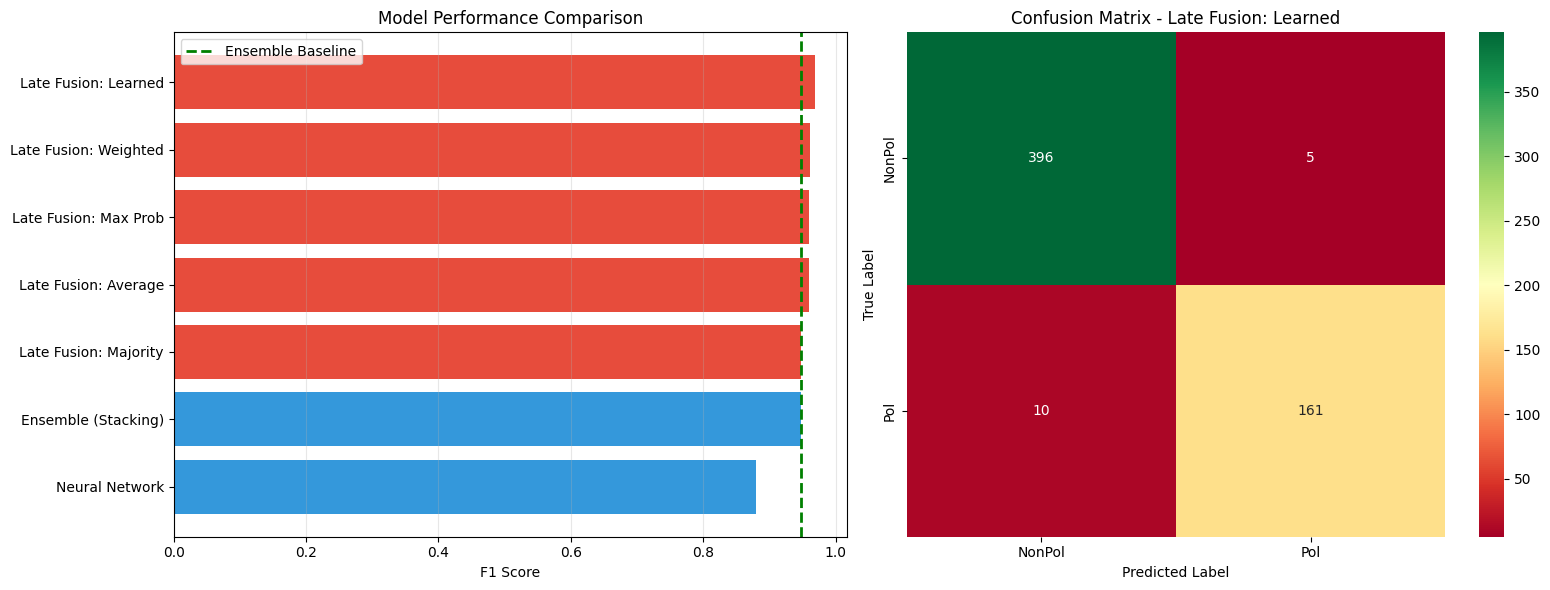


✓ Comparison plot saved as 'late_fusion_comparison.png'


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for comparison
results_sorted = results.sort_values('F1 Score', ascending=True)
colors = ['#3498db' if 'Late Fusion' not in m else '#e74c3c' for m in results_sorted['Model']]

ax1.barh(results_sorted['Model'], results_sorted['F1 Score'], color=colors)
ax1.set_xlabel('F1 Score')
ax1.set_title('Model Performance Comparison')
ax1.axvline(x=ensemble_f1, color='green', linestyle='--', linewidth=2, label='Ensemble Baseline')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Confusion matrix for best method
if best_method_name == 'Late Fusion: Average':
    best_preds = avg_preds_val
elif best_method_name == 'Late Fusion: Weighted':
    best_preds = weighted_preds_val
elif best_method_name == 'Late Fusion: Max Prob':
    best_preds = max_vote_preds_val
elif best_method_name == 'Late Fusion: Majority':
    best_preds = majority_preds_val
else:
    best_preds = fusion_preds_val

cm = confusion_matrix(y_val, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax2,
            xticklabels=['NonPol', 'Pol'], yticklabels=['NonPol', 'Pol'])
ax2.set_title(f'Confusion Matrix - {best_method_name}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('assetslate_fusion_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved as 'assets/late_fusion_comparison.png'")

### STEP 7: Generate Test Predictions with Best Method

In [79]:
print("\n" + "="*60)
print("GENERATING TEST PREDICTIONS WITH BEST METHOD")
print("="*60)

# Apply best method to test set
if best_method_name == 'Late Fusion: Average':
    test_proba_late_fusion = (nn_proba_test_2d + ensemble_proba_test) / 2
    
elif best_method_name == 'Late Fusion: Weighted':
    test_proba_late_fusion = w_nn * nn_proba_test_2d + w_ensemble * ensemble_proba_test
    
elif best_method_name == 'Late Fusion: Max Prob':
    max_nn_test = np.max(nn_proba_test_2d, axis=1)
    max_ensemble_test = np.max(ensemble_proba_test, axis=1)
    test_preds_late_fusion = np.where(
        max_nn_test > max_ensemble_test,
        np.argmax(nn_proba_test_2d, axis=1),
        np.argmax(ensemble_proba_test, axis=1)
    )
    
elif best_method_name == 'Late Fusion: Majority':
    nn_vote_test = nn_preds_test
    ensemble_vote_test = np.argmax(ensemble_proba_test, axis=1)
    test_preds_late_fusion = np.where(
        nn_vote_test == ensemble_vote_test,
        nn_vote_test,
        ensemble_vote_test
    )
    
else:  # Learned Fusion
    fusion_features_test = np.column_stack([
        nn_proba_test_2d[:, 1],
        ensemble_proba_test[:, 1],
        nn_proba_test_2d[:, 1] * ensemble_proba_test[:, 1],
        np.abs(nn_proba_test_2d[:, 1] - ensemble_proba_test[:, 1]),
        np.max(nn_proba_test_2d, axis=1),
        np.max(ensemble_proba_test, axis=1),
    ])
    test_preds_late_fusion = fusion_model.predict(fusion_features_test)

# If we have probabilities, convert to predictions
if 'test_proba_late_fusion' in locals():
    test_preds_late_fusion = np.argmax(test_proba_late_fusion, axis=1)

print(f"\n✓ Using: {best_method_name}")
print(f"  Test predictions generated: {len(test_preds_late_fusion)}")
print(f"  Political: {(test_preds_late_fusion == 1).sum()}")
print(f"  NonPolitical: {(test_preds_late_fusion == 0).sum()}")


GENERATING TEST PREDICTIONS WITH BEST METHOD

✓ Using: Late Fusion: Learned
  Test predictions generated: 330
  Political: 133
  NonPolitical: 197


### STEP 8: Create Final Submission

In [80]:
submission_late_fusion = pd.DataFrame({
    'Image_name': test_text_df['Image_name'],
    'Label': ['Political' if pred == 1 else 'NonPolitical' for pred in test_preds_late_fusion]
})

submission_late_fusion.to_csv('submissions/submission_late_fusion.csv', index=False)

print("\n" + "="*60)
print("FINAL SUBMISSION CREATED")
print("="*60)
print(f"\nFile: submission_late_fusion.csv")
print(f"Method: {best_method_name}")
print(f"Expected Performance (from validation):")
print(f"  Accuracy: {best_f1:.4f}")
print(f"  F1 Score: {best_f1:.4f}")
print(f"\nPrediction distribution:")
print(submission_late_fusion['Label'].value_counts())
print(f"\nFirst 10 predictions:")
print(submission_late_fusion.head(10))
print(f"\n{'='*60}")
print(f"{'='*60}")


FINAL SUBMISSION CREATED

File: submission_late_fusion.csv
Method: Late Fusion: Learned
Expected Performance (from validation):
  Accuracy: 0.9685
  F1 Score: 0.9685

Prediction distribution:
Label
NonPolitical    197
Political       133
Name: count, dtype: int64

First 10 predictions:
     Image_name         Label
0  test0001.jpg  NonPolitical
1  test0002.jpg  NonPolitical
2  test0003.jpg  NonPolitical
3  test0004.jpg     Political
4  test0005.jpg     Political
5  test0006.jpg     Political
6  test0007.jpg  NonPolitical
7  test0008.jpg  NonPolitical
8  test0009.jpg  NonPolitical
9  test0010.jpg  NonPolitical



### Save Late Fusion Model

In [81]:
import pickle
import joblib

print("=" * 60)
print("SAVING LATE FUSION MODEL & COMPONENTS")
print("=" * 60)

# Save the fusion model (if it exists - for "Learned Fusion" method)
if 'fusion_model' in locals():
    joblib.dump(fusion_model, 'models/late_fusion_model.pkl')
    print("✓ Late fusion model saved: models/late_fusion_model.pkl")

# Save the meta-model (ensemble stacking)
joblib.dump(meta_model, 'models/meta_model.pkl')
print("✓ Meta-model (ensemble) saved: models/meta_model.pkl")

# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("✓ Scaler saved: models/scaler.pkl")

# Save best method configuration
best_method_config = {
    'best_method_name': best_method_name,
    'best_f1_score': float(best_f1),
    'weights': {
        'w_nn': float(w_nn) if 'w_nn' in locals() else None,
        'w_ensemble': float(w_ensemble) if 'w_ensemble' in locals() else None
    },
    'validation_metrics': {
        'nn_f1': float(nn_f1_val),
        'ensemble_f1': float(ensemble_f1),
        'text_f1': float(text_f1),
        'image_f1': float(image_f1)
    }
}

with open('models/late_fusion_config.pkl', 'wb') as f:
    pickle.dump(best_method_config, f)
print("✓ Late fusion configuration saved: models/late_fusion_config.pkl")

print("\n" + "=" * 60)
print("SAVED MODELS SUMMARY")
print("=" * 60)
print(f"\nBest Method: {best_method_name}")
print(f"Validation F1 Score: {best_f1:.4f}")
print(f"\nSaved Files:")
print("  1. models/late_fusion_model.pkl (Fusion meta-model)")
print("  2. models/meta_model.pkl (Stacking ensemble meta-model)")
print("  3. models/scaler.pkl (Feature scaler for Neural Network)")
print("  4. models/late_fusion_config.pkl (Configuration & metrics)")
print("\nPre-existing models (required for inference):")
print("  5. models/neural_network_model.pth (Neural Network)")
print("  6. models/mbert_model.pth (mBERT text model)")
print("  7. models/clip_model.pth (CLIP image model)")
print("\n" + "=" * 60)

SAVING LATE FUSION MODEL & COMPONENTS
✓ Late fusion model saved: models/late_fusion_model.pkl
✓ Meta-model (ensemble) saved: models/meta_model.pkl
✓ Scaler saved: models/scaler.pkl
✓ Late fusion configuration saved: models/late_fusion_config.pkl

SAVED MODELS SUMMARY

Best Method: Late Fusion: Learned
Validation F1 Score: 0.9685

Saved Files:
  1. models/late_fusion_model.pkl (Fusion meta-model)
  2. models/meta_model.pkl (Stacking ensemble meta-model)
  3. models/scaler.pkl (Feature scaler for Neural Network)
  4. models/late_fusion_config.pkl (Configuration & metrics)

Pre-existing models (required for inference):
  5. models/neural_network_model.pth (Neural Network)
  6. models/mbert_model.pth (mBERT text model)
  7. models/clip_model.pth (CLIP image model)



### STEP 9: Summary Report

In [ ]:
print("\n" + "="*60)
print("LATE FUSION - FINAL SUMMARY")
print("="*60)

print("\n MODEL ARCHITECTURE:")
print("   Model 1: Neural Network (3 hidden layers)")
print("           - Input: political_specific_count, political_specific_ratio")
print("           - Architecture: 64→32→16→1 neurons")
print("   ")
print("   Model 2: Stacking Ensemble")
print("           - Base models: mBERT (text) + CLIP (image)")
print("           - Meta-model: Logistic Regression")
print("           - Features: 14 engineered features")

print("\n PERFORMANCE PROGRESSION:")
print(f"   Neural Network:     F1={nn_f1_val:.4f}")
print(f"   Ensemble:           F1={ensemble_f1:.4f}")
print(f"   Late Fusion (Best): F1={best_f1:.4f}")
print(f"   ")
print(f"   Improvement: +{(best_f1 - max(nn_f1_val, ensemble_f1))*100:.2f}%")

print("\n LATE FUSION METHOD:")
print(f"   Selected: {best_method_name}")
print(f"   Combines: Neural Network + Stacking Ensemble")

print("\n OUTPUT FILES:")
print("   1. submission_late_fusion.csv (FINAL - BEST)")
print("   2. assets/late_fusion_comparison.png")

print(f"\n{'='*60}")


LATE FUSION - FINAL SUMMARY

 MODEL ARCHITECTURE:
   Model 1: Neural Network (3 hidden layers)
           - Input: political_specific_count, political_specific_ratio
           - Architecture: 64→32→16→1 neurons
   
   Model 2: Stacking Ensemble
           - Base models: mBERT (text) + CLIP (image)
           - Meta-model: Logistic Regression
           - Features: 14 engineered features

 PERFORMANCE PROGRESSION:
   Neural Network:     F1=0.8799
   Ensemble:           F1=0.9478
   Late Fusion (Best): F1=0.9685
   
   Improvement: +2.07%

 LATE FUSION METHOD:
   Selected: Late Fusion: Learned
   Combines: Neural Network + Stacking Ensemble

 OUTPUT FILES:
   1. submission_late_fusion.csv (FINAL - BEST)
   2. late_fusion_comparison.png

